# LSGANs - Least Squares Generative Adversarial Networks

Brief introduction to Least Squares Generative Adversarial Networks or LSGANs. This notebook is organized as follows:

1. **Research Paper**
* **Background**
* **Definition**
* **Training WGAN with MNIST dataset, Keras and TensorFlow**


## 1. Research Paper

* [Least Squares Generative Adversarial Networks](https://arxiv.org/pdf/1611.04076.pdf)

## 2. Background

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The **value function** $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V_{GAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

## 3. Definition

Least Squares Generative Adversarial Networks (LSGANs) adopt the **least squares loss function** for the discriminator. 

The least squares loss function is able to move the fake samples toward the decision boundary, because the least squares loss function penalizes samples that lie in a long way on the correct side of the decision boundary. 

Another benefit of LSGANs is the improved stability of learning process.

### Network Design

<img src="../../img/network_design_gan.png" width="600"> 


### Cost Funcion

$$ 
\begin{aligned}
    \underset{D}{min} \; V_{LSGAN}(D,G) =& \frac{1}{2} \mathbb{E}_{x\sim p_{data}(x)}[D(x)-b^2] + \frac{1}{2} \mathbb{E}_{z\sim p_{z}(z)}[(D(G(z))-a^2)] \\
    \underset{G}{min} \; V_{LSGAN}(D,G) =& \frac{1}{2} \mathbb{E}_{z\sim p_{z}(z)}[(D(G(z))-c^2)]
\end{aligned}
$$

where $a$ and $b$ are the labels for fake data and real data, respectively, and $c$ denotes the value that G wants D to believe for fake data.

## 4. Training LSGANs with MNIST dataset, Keras and TensorFlow

* Data
    * Rescale the MNIST images to be between -1 and 1.

* Generator
    * **Simple fully connected neural network**, **LeakyReLU activation** and **BatchNormalization**.
    * The input to the generator is called 'latent sample' (100 values) which is a series of randomly generated numbers, and produces 784 (=28x28) data points which represent a digit image. We use the **normal distribution**.
        The last activation is **tanh**.

* Discriminator
    * **Simple fully connected neural network** and **LeakyReLU activation**.
    * The last activation is **sigmoid**.

*  Loss
    * loss='mse'

* Optimizer
    * Adam(lr=0.0002, beta_1=0.5)

* batch_size = 64
* epochs = 100


### 1. Load data

#### Load libraries

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Input, Flatten, Reshape
from keras.optimizers import Adam
from keras import initializers
from keras import backend as K

Using TensorFlow backend.


#### Getting the data

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#### Explore visual data

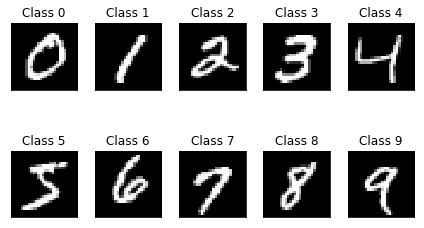

In [4]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [5]:
print('X_train.shape', X_train.shape)

# reshaping the inputs
X_train = X_train.reshape(60000, 28*28)
# normalizing the inputs (-1, 1)
X_train = (X_train.astype('float32') / 255 - 0.5) * 2

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
X_train reshape: (60000, 784)


### 2. Define model

#### Generator


In [6]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28x1
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# Input layer and hidden layer 1
generator.add(Dense(128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 2
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 3
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Output layer 
generator.add(Dense(img_dim, activation='tanh'))

#### Generator model visualization

In [7]:
# prints a summary representation of your model
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
__________

#### Discriminator

In [8]:
# Discriminator network
discriminator = Sequential()

# Hidden layer 1
discriminator.add(Dense(128, input_shape=(img_dim,), kernel_initializer=init))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 2
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 3
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))

# Output layer
discriminator.add(Dense(1))

#### Discriminator model visualization

In [9]:
# prints a summary representation of your model
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total para

### 3. Compile model

#### Compile discriminator

In [10]:
# Optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss='mse', metrics=['binary_accuracy'])

#### Combined network

In [11]:
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

# Optimize w.r.t. MSE loss instead of crossentropy
d_g.compile(optimizer=optimizer, loss='mse', metrics=['binary_accuracy'])

In [12]:
# prints a summary representation of your model
d_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               583312    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 265601    
Total params: 848,913
Trainable params: 581,520
Non-trainable params: 267,393
_________________________________________________________________


### 4. Fit model


epoch = 1/100, d_loss=0.172, g_loss=0.652                                                                                                                                                                                                                            


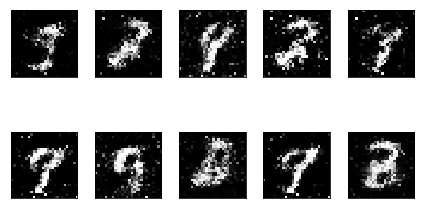

epoch = 2/100, d_loss=0.140, g_loss=0.677                                                                                                                        
epoch = 3/100, d_loss=0.105, g_loss=0.674                                                                                                                        
epoch = 4/100, d_loss=0.104, g_loss=0.753                                                                                                                                                                                                                                                                                                                              
epoch = 5/100, d_loss=0.102, g_loss=0.744                                                                                                                        
epoch = 6/100, d_loss=0.093, g_loss=0.653                                                                                                                 

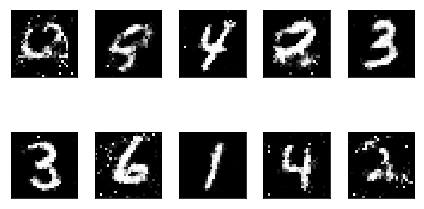

epoch = 12/100, d_loss=0.095, g_loss=0.665                                                                                                                        
epoch = 13/100, d_loss=0.075, g_loss=0.670                                                                                                                                                                                                                                                                                                                               
epoch = 14/100, d_loss=0.083, g_loss=0.767                                                                                                                        
epoch = 15/100, d_loss=0.092, g_loss=0.759                                                                                                                        
epoch = 16/100, d_loss=0.115, g_loss=0.676                                                                                                           

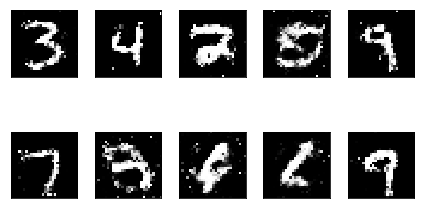

epoch = 22/100, d_loss=0.113, g_loss=0.628                                                                                                                        
epoch = 23/100, d_loss=0.095, g_loss=0.743                                                                                                                        
epoch = 24/100, d_loss=0.100, g_loss=0.761                                                                                                                        
epoch = 25/100, d_loss=0.074, g_loss=0.741                                                                                                                        
epoch = 26/100, d_loss=0.079, g_loss=0.641                                                                                                                        
epoch = 27/100, d_loss=0.105, g_loss=0.849                                                                                                                        
epoch = 28/100, d_loss

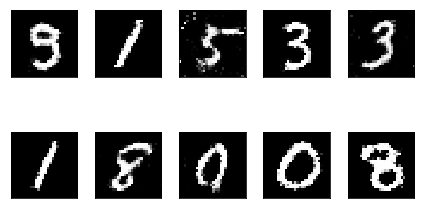

epoch = 32/100, d_loss=0.090, g_loss=0.772                                                                                                                        
epoch = 33/100, d_loss=0.059, g_loss=0.713                                                                                                                        
epoch = 34/100, d_loss=0.073, g_loss=0.697                                                                                                                        
epoch = 35/100, d_loss=0.110, g_loss=0.746                                                                                                                        
epoch = 36/100, d_loss=0.120, g_loss=0.707                                                                                                                        
epoch = 37/100, d_loss=0.096, g_loss=0.736                                                                                                                        
epoch = 38/100, d_loss

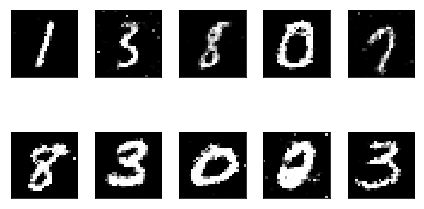

epoch = 42/100, d_loss=0.087, g_loss=0.727                                                                                                                        
epoch = 43/100, d_loss=0.092, g_loss=0.654                                                                                                                        
epoch = 44/100, d_loss=0.095, g_loss=0.652                                                                                                                        
epoch = 45/100, d_loss=0.086, g_loss=0.732                                                                                                                        
epoch = 46/100, d_loss=0.082, g_loss=0.807                                                                                                                        
epoch = 47/100, d_loss=0.090, g_loss=0.732                                                                                                                        
epoch = 48/100, d_loss

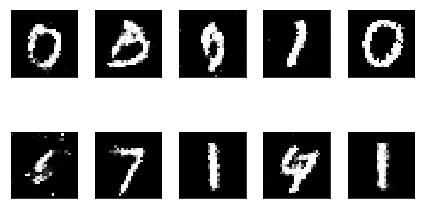

epoch = 52/100, d_loss=0.102, g_loss=0.721                                                                                                                        
epoch = 53/100, d_loss=0.082, g_loss=0.774                                                                                                                        
epoch = 54/100, d_loss=0.107, g_loss=0.760                                                                                                                        
epoch = 55/100, d_loss=0.091, g_loss=0.753                                                                                                                        
epoch = 56/100, d_loss=0.103, g_loss=0.681                                                                                                                        
epoch = 57/100, d_loss=0.069, g_loss=0.738                                                                                                                        
epoch = 58/100, d_loss

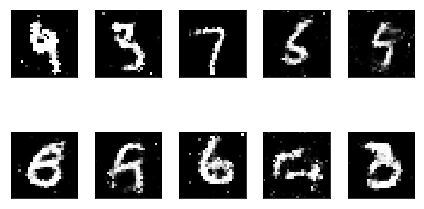

epoch = 62/100, d_loss=0.069, g_loss=0.765                                                                                                                        
epoch = 63/100, d_loss=0.100, g_loss=0.753                                                                                                                        
epoch = 64/100, d_loss=0.071, g_loss=0.884                                                                                                                        
epoch = 65/100, d_loss=0.080, g_loss=0.747                                                                                                                        
epoch = 66/100, d_loss=0.103, g_loss=0.703                                                                                                                        
epoch = 67/100, d_loss=0.101, g_loss=0.709                                                                                                                        
epoch = 68/100, d_loss

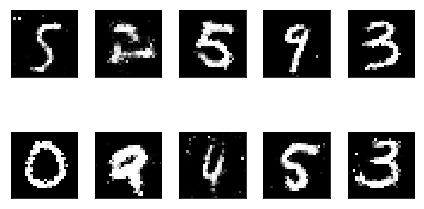

epoch = 72/100, d_loss=0.092, g_loss=0.744                                                                                                                        
epoch = 73/100, d_loss=0.082, g_loss=0.766                                                                                                                        
epoch = 74/100, d_loss=0.122, g_loss=0.730                                                                                                                        
epoch = 75/100, d_loss=0.075, g_loss=0.841                                                                                                                        
epoch = 76/100, d_loss=0.086, g_loss=0.781                                                                                                                                                                                                                            
epoch = 77/100, d_loss=0.132, g_loss=0.683                                           

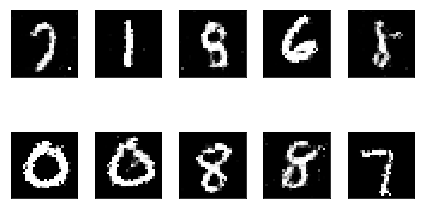

epoch = 82/100, d_loss=0.099, g_loss=0.801                                                                                                                        
epoch = 83/100, d_loss=0.076, g_loss=0.753                                                                                                                        
epoch = 84/100, d_loss=0.072, g_loss=0.631                                                                                                                        
epoch = 85/100, d_loss=0.080, g_loss=0.773                                                                                                                        
epoch = 86/100, d_loss=0.086, g_loss=0.886                                                                                                                                                                                                                            
epoch = 87/100, d_loss=0.110, g_loss=0.940                                           

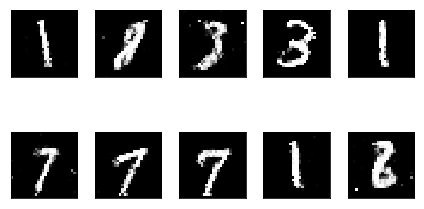

epoch = 92/100, d_loss=0.078, g_loss=0.878                                                                                                                        
epoch = 93/100, d_loss=0.087, g_loss=0.846                                                                                                                        
epoch = 94/100, d_loss=0.081, g_loss=0.798                                                                                                                        
epoch = 95/100, d_loss=0.076, g_loss=0.847                                                                                                                        
epoch = 96/100, d_loss=0.067, g_loss=0.747                                                                                                                        
epoch = 97/100, d_loss=0.075, g_loss=0.788                                                                                                                        
epoch = 98/100, d_loss

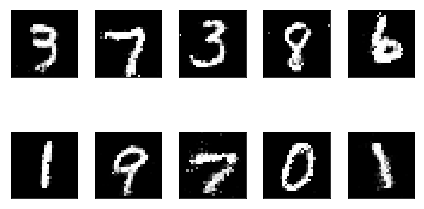

In [13]:
epochs = 100
batch_size = 32
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch, y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        d_g_loss_batch = d_g.train_on_batch(x=z, y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

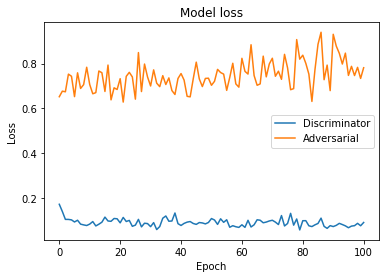

In [14]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()